Install Packages/Libraries

In [1]:
%pip install --upgrade pip
%pip install torch torchaudio
%pip install torchvision --index-url https://download.pytorch.org/whl/cu124

%pip install pandas
%pip install datasets
%pip install peft
%pip install transformers
%pip install transformers[torch]
%pip install 'accelerate>=0.26.0'

%pip install matplotlib

%pip install evaluate
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchaudio-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_

Import Packages/Libraries

In [2]:
import os, re, glob,math, torch, time, evaluate, pandas as pd, matplotlib.pyplot as plt, numpy as np
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import (
    GPT2TokenizerFast,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer, TrainingArguments, TrainerCallback
)
from peft import get_peft_model, LoraConfig, TaskType

Configurations

In [3]:
USE_LORA                    = False
DATA_DIR                    = "outputs/github-ts-output-formatted"
METADATA_CSV                = "outputs/github-ts-output-types.csv"
OUTPUT_DIR                  = "outputs/typescriptmate-500000"
BATCH_SIZE                  = 4
MAX_LENGTH                  = 512
EPOCHS                      = 5
LR                          = 5e-5
GRAD_CLIP                   = 0.0
SEED                        = 42
WEIGHT_DECAY                = 0.01
GRADIENT_ACCUMULATION_STEPS = 2

Count number of TypeScipt files in folder

In [4]:
file_count = sum(len(files) for _, _, files in os.walk(DATA_DIR))
print("Total files:", file_count)

Total files: 379349


Check if MPS (Accelerated PyTorch Training for Apple Silicon) is supported

In [5]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())


False
False


Load metadata for Type Awareness

In [6]:
df = pd.read_csv(METADATA_CSV)
metadata_cols = [
    "Interfaces", "TypeAliases", "Enums",
    "Classes", "Decorators", "Imports",
    "Exports", "PredefinedTypesUsed"
]
for col in metadata_cols:
    if col in df.columns:
        df[col] = df[col].fillna("")
print(f"Loaded {len(df)} metadata rows")

Loaded 378001 metadata rows


Attach file text

In [7]:
dataset_meta = Dataset.from_pandas(df, preserve_index=False)

def add_text_and_metadata(example):
    path = example["File"]
    if not os.path.isabs(path):
        path = os.path.join(DATA_DIR, path)

    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            example["text"] = f.read()
    except FileNotFoundError:
        example["text"] = ""

    example["interfaces"] = example.get("Interfaces", "")
    example["type_aliases"] = example.get("TypeAliases", "")
    example["enums"] = example.get("Enums", "")
    example["classes"] = example.get("Classes", "")
    example["decorators"] = example.get("Decorators", "")
    example["imports"] = example.get("Imports", "")
    example["exports"] = example.get("Exports", "")
    example["predefined_types"] = example.get("PredefinedTypesUsed", "")
    return example

dataset_meta = dataset_meta.map(add_text_and_metadata, batched=False)
print(dataset_meta)

Map:   0%|          | 0/378001 [00:00<?, ? examples/s]

Dataset({
    features: ['File', 'Interfaces', 'TypeAliases', 'Enums', 'Classes', 'Decorators', 'Imports', 'Exports', 'PredefinedTypesUsed', 'text', 'interfaces', 'type_aliases', 'enums', 'classes', 'decorators', 'imports', 'exports', 'predefined_types'],
    num_rows: 378001
})


Filter bad examples

In [8]:
dataset_meta = dataset_meta.filter(lambda ex: ex["text"].strip() != "")
print("Non-empty examples:", len(dataset_meta))

Filter:   0%|          | 0/378001 [00:00<?, ? examples/s]

Non-empty examples: 377717


Split and filter train and validation data for annotated examples

In [9]:
splits = dataset_meta.train_test_split(test_size=0.1, seed=SEED)
datasets = DatasetDict({
    "train": splits["train"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"]),
    "validation": splits["test"].filter(lambda ex: ex["TypeAliases"] or ex["Interfaces"])
})
print("Filtered split:")
print("  • train:", len(datasets["train"]))
print("  • validation:", len(datasets["validation"]))

Filter:   0%|          | 0/339945 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37772 [00:00<?, ? examples/s]

Filtered split:
  • train: 77183
  • validation: 8606


Tokenize

In [10]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_attention_mask=True,
    )

tokenized = datasets.map(
    tokenize_fn,
    batched=True,
    remove_columns=datasets["train"].column_names
)

Map:   0%|          | 0/77183 [00:00<?, ? examples/s]

Map:   0%|          | 0/8606 [00:00<?, ? examples/s]

Sanity check on tokens

In [11]:
valid_count = sum(
    any(tok != tokenizer.eos_token_id for tok in ex["input_ids"])
    for ex in tokenized["train"]
)
print(f"Usable tokenized examples: {valid_count} / {len(tokenized['train'])}")

Usable tokenized examples: 77183 / 77183


Collator & base Model

In [12]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=None,
)
base_model = AutoModelForCausalLM.from_pretrained("gpt2")
base_model.config.pad_token_id = base_model.config.eos_token_id

Apply LoRA if enabled

In [13]:
if USE_LORA:
    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        r=338,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        target_modules=["c_attn", "q_attn", "v_attn"]
    )
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
else:
    model = base_model

Move model to supported device

In [14]:
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

model.to(device)

Using device: cuda


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

TrainingArguments

In [15]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS, 
    num_train_epochs=EPOCHS,
    learning_rate=LR,
    weight_decay=WEIGHT_DECAY, 
    max_grad_norm=GRAD_CLIP,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    logging_strategy="steps",
    eval_strategy="steps",
    save_strategy="steps",
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    push_to_hub=True,
)

Trainer with loss logger

In [16]:
class LossLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        print("LOGS:", logs)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
    callbacks=[LossLogger()]
)

Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Training

In [17]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,1.801100,1.653206
1000,1.678000,1.555488
1500,1.594200,1.503911
2000,1.556800,1.467118
2500,1.559500,1.437249
3000,1.512600,1.411668
3500,1.480600,1.392614
4000,1.445100,1.376371
4500,1.427400,1.359927
5000,1.433000,1.346641


LOGS: {'loss': 2.219, 'learning_rate': 4.989738805970149e-05, 'epoch': 0.010364842454394693}
LOGS: {'loss': 1.9512, 'learning_rate': 4.9793739635157546e-05, 'epoch': 0.020729684908789386}
LOGS: {'loss': 1.8667, 'learning_rate': 4.96900912106136e-05, 'epoch': 0.03109452736318408}
LOGS: {'loss': 1.7901, 'learning_rate': 4.958644278606965e-05, 'epoch': 0.04145936981757877}
LOGS: {'loss': 1.8011, 'learning_rate': 4.948279436152571e-05, 'epoch': 0.051824212271973466}
LOGS: {'eval_loss': 1.6532058715820312, 'eval_runtime': 145.9924, 'eval_samples_per_second': 58.948, 'eval_steps_per_second': 14.74, 'epoch': 0.051824212271973466}
LOGS: {'loss': 1.7528, 'learning_rate': 4.937914593698176e-05, 'epoch': 0.06218905472636816}
LOGS: {'loss': 1.7187, 'learning_rate': 4.9275497512437814e-05, 'epoch': 0.07255389718076286}
LOGS: {'loss': 1.7019, 'learning_rate': 4.917184908789387e-05, 'epoch': 0.08291873963515754}
LOGS: {'loss': 1.6759, 'learning_rate': 4.9068200663349915e-05, 'epoch': 0.09328358208955

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


LOGS: {'train_runtime': 34607.5792, 'train_samples_per_second': 11.151, 'train_steps_per_second': 1.394, 'total_flos': 1.0083651452928e+17, 'train_loss': 1.2370609298471986, 'epoch': 5.0}


TrainOutput(global_step=48240, training_loss=1.2370609298471986, metrics={'train_runtime': 34607.5792, 'train_samples_per_second': 11.151, 'train_steps_per_second': 1.394, 'total_flos': 1.0083651452928e+17, 'train_loss': 1.2370609298471986, 'epoch': 5.0})

Save model, tokenizer and deploy

In [18]:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
trainer.save_model(OUTPUT_DIR)

Basic evaluation

In [19]:
eval_results = trainer.evaluate()

print("Full eval results:", eval_results)

if eval_results.get("eval_loss") is not None and not math.isnan(eval_results["eval_loss"]):
    print("Validation Perplexity: ", math.exp(eval_results["eval_loss"]))
else:
    print("NaN eval loss")

LOGS: {'eval_loss': 1.113566279411316, 'eval_runtime': 144.3442, 'eval_samples_per_second': 59.621, 'eval_steps_per_second': 14.909, 'epoch': 5.0}
Full eval results: {'eval_loss': 1.113566279411316, 'eval_runtime': 144.3442, 'eval_samples_per_second': 59.621, 'eval_steps_per_second': 14.909, 'epoch': 5.0}
Validation Perplexity:  3.0451990832773794


Convert the trainer log history into a DataFrame

In [20]:
logs = trainer.state.log_history
df = pd.DataFrame(logs)
print(df)

       loss  learning_rate     epoch   step  eval_loss  eval_runtime  \
0    2.2190   4.989739e-05  0.010365    100        NaN           NaN   
1    1.9512   4.979374e-05  0.020730    200        NaN           NaN   
2    1.8667   4.969009e-05  0.031095    300        NaN           NaN   
3    1.7901   4.958644e-05  0.041459    400        NaN           NaN   
4    1.8011   4.948279e-05  0.051824    500        NaN           NaN   
..      ...            ...       ...    ...        ...           ...   
575     NaN            NaN  4.975124  48000   1.113566      147.1382   
576  1.1368   1.461443e-07  4.985489  48100        NaN           NaN   
577  1.1046   4.249585e-08  4.995854  48200        NaN           NaN   
578     NaN            NaN  5.000000  48240        NaN           NaN   
579     NaN            NaN  5.000000  48240   1.113566      144.3442   

     eval_samples_per_second  eval_steps_per_second  train_runtime  \
0                        NaN                    NaN            Na

Plot training loss vs global step

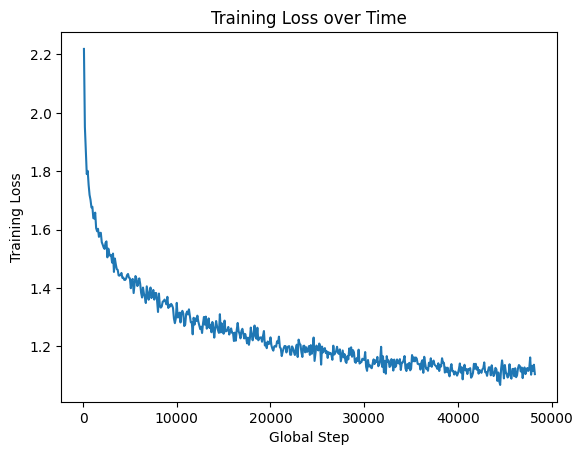

In [21]:
train_df = df[df["loss"].notna()]
plt.plot(train_df["step"], train_df["loss"])
plt.xlabel("Global Step")
plt.ylabel("Training Loss")
plt.title("Training Loss over Time")
plt.show()

Plot training perplexity vs global step

/tmp/ipykernel_927/702312287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["perplexity"] = train_df["loss"].apply(math.exp)


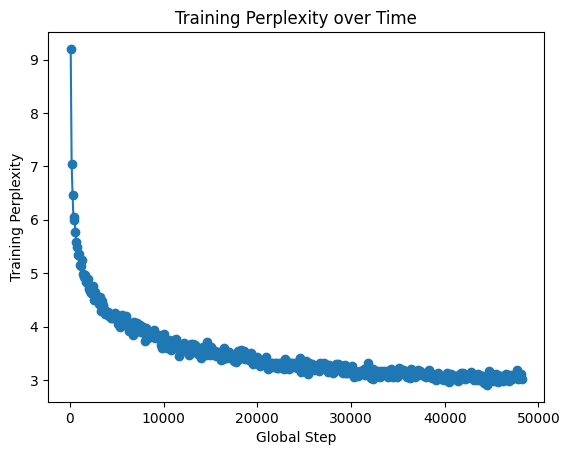

In [22]:
train_df["perplexity"] = train_df["loss"].apply(math.exp)
plt.figure()
plt.plot(train_df["step"], train_df["perplexity"], marker="o")
plt.xlabel("Global Step")
plt.ylabel("Training Perplexity")
plt.title("Training Perplexity over Time")
plt.show()

Load each checkpoint’s weights into your model

In [23]:
ckpt_paths = glob.glob(os.path.join(OUTPUT_DIR, "checkpoint-*"))

ckpt_paths = sorted(
    ckpt_paths,
    key=lambda p: int(re.search(r"checkpoint-(\d+)$", p).group(1))
)

print(ckpt_paths)

records = []
for ckpt_path in ckpt_paths:
    # 1) Reload the model weights
    model = AutoModelForCausalLM.from_pretrained(ckpt_path)
    model.to(trainer.args.device)

    # 2) Patch the Trainer’s model
    trainer.model = model

    # 3) Run evaluation on your validation split
    metrics = trainer.evaluate()        # no args here

    # 4) Record step & loss (& perplexity)
    step = int(ckpt_path.split("-")[-1])
    loss = metrics["eval_loss"]
    records.append({
      "step": step,
      "eval_loss": loss,
      "perplexity": math.exp(loss)
    })

df = pd.DataFrame(records).sort_values("step")

['outputs/typescriptmate-500000/checkpoint-500', 'outputs/typescriptmate-500000/checkpoint-1000', 'outputs/typescriptmate-500000/checkpoint-1500', 'outputs/typescriptmate-500000/checkpoint-2000', 'outputs/typescriptmate-500000/checkpoint-2500', 'outputs/typescriptmate-500000/checkpoint-3000', 'outputs/typescriptmate-500000/checkpoint-3500', 'outputs/typescriptmate-500000/checkpoint-4000', 'outputs/typescriptmate-500000/checkpoint-4500', 'outputs/typescriptmate-500000/checkpoint-5000', 'outputs/typescriptmate-500000/checkpoint-5500', 'outputs/typescriptmate-500000/checkpoint-6000', 'outputs/typescriptmate-500000/checkpoint-6500', 'outputs/typescriptmate-500000/checkpoint-7000', 'outputs/typescriptmate-500000/checkpoint-7500', 'outputs/typescriptmate-500000/checkpoint-8000', 'outputs/typescriptmate-500000/checkpoint-8500', 'outputs/typescriptmate-500000/checkpoint-9000', 'outputs/typescriptmate-500000/checkpoint-9500', 'outputs/typescriptmate-500000/checkpoint-10000', 'outputs/typescript

Plot evaluation loss vs global step

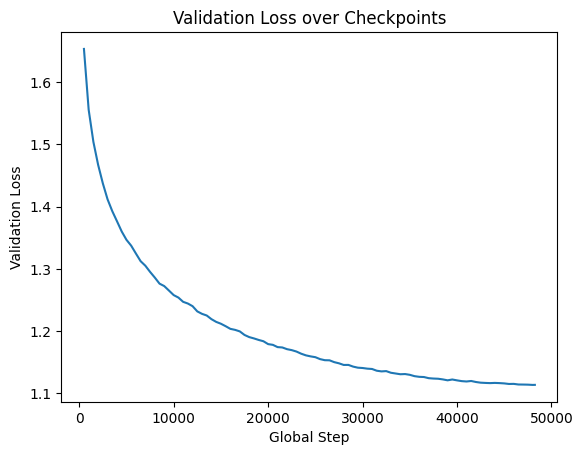

In [24]:
plt.figure()
plt.plot(df["step"], df["eval_loss"])
plt.xlabel("Global Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Checkpoints")
plt.show()

Convert loss to perplexity for easier interpretation: perplexity = exp(loss)

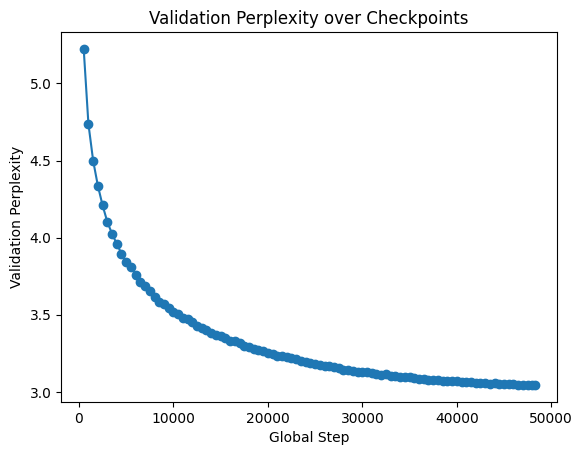

In [25]:
plt.figure()
plt.plot(df["step"], df["perplexity"], marker="o")
plt.xlabel("Global Step")
plt.ylabel("Validation Perplexity")
plt.title("Validation Perplexity over Checkpoints")
plt.show()

Top-5 Token Accuracy and MRR over validation set

In [26]:
def stream_topk_mrr(model, trainer, k=5, batch_size=1):
    """
    Streams through the Trainer’s eval_dataloader batch-by-batch,
    accumulates top-k matches and reciprocal ranks,
    and keeps memory use small.
    """
    # Put model in eval mode & grab device
    model.eval()
    device = next(model.parameters()).device
    
    # Use the Trainer’s built-in eval dataloader (with correct collation)
    loader: DataLoader = trainer.get_eval_dataloader()
    
    total_tokens = 0
    topk_matches = 0
    rr_sum = 0.0

    with torch.no_grad():
        for batch in loader:
            # batch is a dict of torch.Tensor already
            labels = batch.pop("labels").to(device)   # shape (bs, seq_len)
            # move all other inputs to device
            inputs = {k: v.to(device) for k, v in batch.items()}
            
            # forward
            logits = model(**inputs).logits.cpu().numpy()  # (bs, seq_len, vocab_size)
            lbls   = labels.cpu().numpy()                 # (bs, seq_len)

            # mask out padding tokens
            mask = lbls != -100                             # (bs, seq_len)
            flat_logits = logits[mask].reshape(-1, logits.shape[-1])  # (N_toks, V)
            flat_labels = lbls[mask].reshape(-1)                     # (N_toks,)

            # Top-k matches via argpartition (cheap per-row)
            topk_idxs = np.argpartition(flat_logits, -k, axis=-1)[:, -k:]
            topk_matches += np.sum([flat_labels[i] in topk_idxs[i]
                                    for i in range(flat_labels.shape[0])])

            # MRR: rank = 1 + # of logits > true_logit
            true_scores = flat_logits[np.arange(flat_labels.shape[0]), flat_labels]
            ranks = 1 + np.sum(flat_logits > true_scores[:, None], axis=1)
            rr_sum += np.sum(1.0 / ranks)

            total_tokens += flat_labels.shape[0]

    topk_acc = topk_matches / total_tokens
    mrr      = rr_sum / total_tokens
    return topk_acc, mrr

# Usage:
top5_acc, mrr = stream_topk_mrr(model, trainer, k=5)
print(f"Top-5 Accuracy: {top5_acc:.4f}")
print(f"MRR:             {mrr:.4f}")


Top-5 Accuracy: 0.1719
MRR:             0.1369


Top-5 Accuracy bar chart

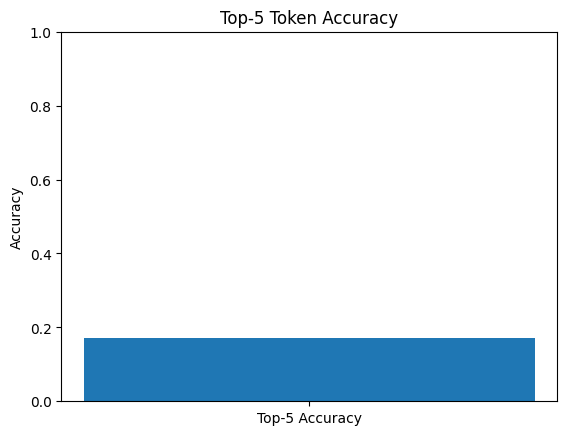

In [27]:
plt.figure()
plt.bar(['Top-5 Accuracy'], [top5_acc])
plt.ylim(0, 1)
plt.title('Top-5 Token Accuracy')
plt.ylabel('Accuracy')
plt.show()

MRR bar chart

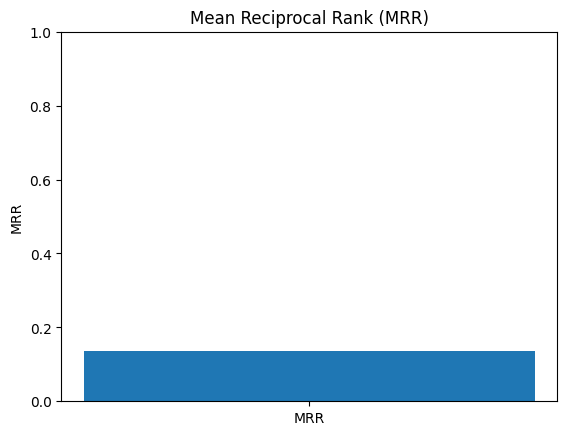

In [28]:
plt.figure()
plt.bar(['MRR'], [mrr])
plt.ylim(0, 1)
plt.title('Mean Reciprocal Rank (MRR)')
plt.ylabel('MRR')
plt.show()

Inference Latency Histogram
Measure per-sample inference latency and visualize

Mean latency: 0.0061s
Std  latency: 0.0002s


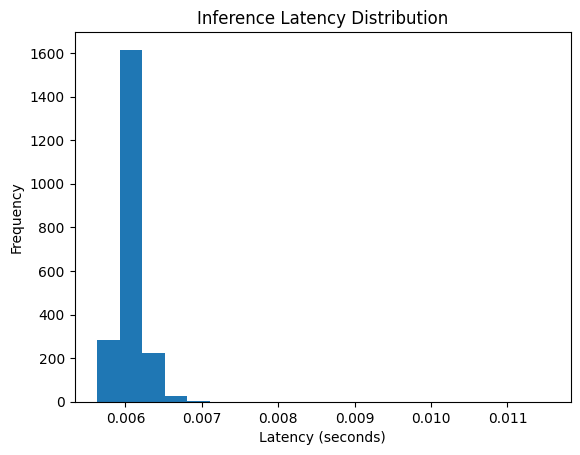

In [29]:
model.eval()
device = next(model.parameters()).device
loader = trainer.get_eval_dataloader()

latencies = []
with torch.no_grad():
    for batch in loader:
        batch.pop("labels", None)
        inputs = {k: v.to(device) for k, v in batch.items()}
        start = time.monotonic()
        _ = model(**inputs)
        end = time.monotonic()
        latencies.append(end - start)

latencies = np.array(latencies)

print(f"Mean latency: {latencies.mean():.4f}s")
print(f"Std  latency: {latencies.std():.4f}s")

plt.figure()
plt.hist(latencies, bins=20)
plt.xlabel("Latency (seconds)")
plt.ylabel("Frequency")
plt.title("Inference Latency Distribution")
plt.show()
